# Workspace preparation

Install all the deps for hackathon

In [26]:
# !sudo apt install build-essential python3-dev libopenblas-dev
# !pip install torch ninja
# !pip install -U git+https://github.com/richlukich/MinkowskiEngine -v --no-deps \
#                           --config-settings="--install-option=--force_cuda" \
#                           --config-settings="--install-option=--blas=openblas"!pip install faiss-gpu
# !pip install loguru
# !pip install fuzzywuzzy
# !pip install paddlepaddle
# !pip install paddleocr==2.8.0 --no-deps
# !pip install numpy-quaternion
# !pip install dvc
# !pip install dvc_gdrive

In [27]:
# import torch
# print(f"Is CUDA available in torch?: {torch.cuda.is_available()}")
# import MinkowskiEngine as ME
# print(f"Is CUDA available in MinkowskiEngine?: {ME.is_cuda_available()}")
# ME.print_diagnostics()

Install OpenPlaceRecognition library

In [28]:
# !git clone https://github.com/OPR-Project/OpenPlaceRecognition.git
# !git clone -b feat/itlp_outdoor https://github.com/alexmelekhin/open_place_recognition
# !git clone https://github.com/b-l-a-i-n/OpenPlaceRecognition.git open_place_recognition
%cd ../

# %cd open_place_recognition

!pip install -e .

%cd notebooks

# # load submodules from git
# !git submodule update --init

# # # change dir
# %cd third_party/GeoTransformer/

# # install the package
# !bash setup.sh

# %cd ../../../

# Download available data

In [3]:
import gdown

OPR models weights

In [13]:
%cd open_place_recognition/weights

url = "https://drive.google.com/drive/folders/1uRiMe2-I9b5Tgv8mIJLkdGaHXccp_UFJ"
gdown.download_folder(url, quiet=True)

%cd ../../

/home/docker_opr/beliakin/notebooks/open_place_recognition/weights
/home/docker_opr/beliakin/notebooks


OCR model weights (trained using the PaddleOCR library)  
https://github.com/PaddlePaddle/PaddleOCR

In [7]:
# PaddleOCR Weights

%cd open_place_recognition/weights

url = "https://drive.google.com/drive/u/0/folders/11DKL4FmONL9n6L62ccVDJ1RJ6domQJ5k"
gdown.download_folder(url, quiet=True)

%cd ../../

/home/docker_opr/beliakin/notebooks/open_place_recognition/weights
/home/docker_opr/beliakin/notebooks


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from scipy.spatial.transform import Rotation

import faiss
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from typing import List
from omegaconf import OmegaConf
from hydra.utils import instantiate

# If there is an import error - restart the session
from opr.pipelines.place_recognition import PlaceRecognitionPipeline, TextLabelsPlaceRecognitionPipeline
from opr.pipelines.place_recognition.text_labels import TextLabelsPlaceRecognitionOCRPipeline

import cv2
import os
import matplotlib.pyplot as plt
from opr.models.ocr.paddle import PaddleOcrPipeline
import paddleocr.tools.infer.predict_det as predict_det
from omegaconf import OmegaConf
from tqdm.notebook import tqdm
import pandas as pd

In [3]:
def get_labels_by_id(labels: List[str], id: str):
    frame = labels[id]
    all_labels = [i["value"]["text"] for i in frame["back_cam_anno"] + frame["front_cam_anno"]]
    all_labels = sum(all_labels, [])
    return all_labels

def pose_to_matrix(pose):
    """From the 6D poses in the [tx ty tz qx qy qz qw] format to 4x4 pose matrices."""
    position = pose[:3]
    orientation_quat = pose[3:]
    rotation = Rotation.from_quat(orientation_quat)
    pose_matrix = np.eye(4)
    pose_matrix[:3,:3] = rotation.as_matrix()
    pose_matrix[:3,3] = position
    return pose_matrix

def compute_error(estimated_pose, gt_pose):
    """For the 6D poses in the [tx ty tz qx qy qz qw] format."""
    estimated_pose = pose_to_matrix(estimated_pose)
    gt_pose = pose_to_matrix(gt_pose)
    error_pose = np.linalg.inv(estimated_pose) @ gt_pose
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = Rotation.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / np.pi
    angle_error = abs(90 - abs(angle_error-90))
    return dist_error, angle_error

def compute_translation_error(gt_pose, pred_pose):
    """For the 4x4 pose matrices."""
    gt_trans = gt_pose[:3, 3]
    pred_trans = pred_pose[:3, 3]
    error = np.linalg.norm(gt_trans - pred_trans)
    return error

def compute_rotation_error(gt_pose, pred_pose):
    """For the 4x4 pose matrices."""
    gt_rot = Rotation.from_matrix(gt_pose[:3, :3])
    pred_rot = Rotation.from_matrix(pred_pose[:3, :3])
    error = Rotation.inv(gt_rot) * pred_rot
    error = error.as_euler('xyz', degrees=True)
    error = np.linalg.norm(error)
    return error

def compute_absolute_pose_error(gt_pose, pred_pose):
    """For the 4x4 pose matrices."""
    rotation_error = compute_rotation_error(gt_pose, pred_pose)
    translation_error = compute_translation_error(gt_pose, pred_pose)
    return rotation_error, translation_error

In [35]:
tracks = ["2012-01-22", "2012-01-08"]
df_track = None

for track in tracks:
    df = pd.read_csv(os.path.join(DATABASE_TRACK_DIR, track, "track.csv"), index_col=0)
    if type(df_track) != pd.DataFrame:
        df_track = df
    else:
        df_track = pd.concat([df_track, df], axis=0)
        
df_track.reset_index(drop=True, inplace=True)
df_track.to_csv(os.path.join(DATABASE_TRACK_DIR, "track.csv"))

## NCLT dataset

In [4]:
OPR_PATH = "/home/docker_opr/beliakin/base/OpenPlaceRecognition/"
DATASET_PATH = "/home/docker_opr/Datasets/"

In [5]:
from opr.datasets.nclt import NCLTDataset

QUERY_TRACK_DIR = os.path.join(DATASET_PATH, "NCLT_preprocessed")
DATABASE_TRACK_DIR = os.path.join(DATASET_PATH, "NCLT_preprocessed")

DB_LABELS_PATH = os.path.join(DATABASE_TRACK_DIR, "text_labels.json")

DEVICE = "cuda"

BATCH_SIZE = 4
NUM_WORKERS = 2

MODEL_CONFIG_PATH = os.path.join(OPR_PATH, "configs/model/place_recognition/minkloc3d.yaml")
WEIGHTS_PATH = os.path.join(OPR_PATH, "weights/place_recognition/minkloc3d_nclt.pth")

with open(DB_LABELS_PATH, "r") as f:
    db_labels = json.loads(f.read())

all_db_timestamps = set([int(key) for key in db_labels.keys()])

track_df = pd.read_csv(os.path.join(DATABASE_TRACK_DIR, "track.csv"))

img2ts = {}
                       
for idx, row in track_df.iterrows():
    img2ts[int(row["image"])] = int(row["timestamp"])

In [98]:
db_dataset = NCLTDataset(
    dataset_root=QUERY_TRACK_DIR,
    subset="test",
    data_to_load=["image_Cam2", "image_Cam5", "pointcloud_lidar"],
    images_dirname="images_large",
    use_itlp_format=True,
)
db_dataset.dataset_df = db_dataset.dataset_df[db_dataset.dataset_df.track == "2012-01-08"]
db_dataset.dataset_df = db_dataset.dataset_df[db_dataset.dataset_df.image.apply(lambda x: img2ts[int(x)] in all_db_timestamps)].reset_index(drop=True)
db_dataset.dataset_df["timestamp"] = db_dataset.dataset_df.image.apply(lambda x: img2ts[int(x)])
db_dataset.dataset_df.drop(["in_query"], axis=1, inplace=True)
db_dataset.dataset_df = pd.merge(db_dataset.dataset_df, track_df.drop(["northing", "easting"], axis=1), how="left", on=["image", "pointcloud","timestamp"])

query_dataset = NCLTDataset(
    dataset_root=QUERY_TRACK_DIR,
    subset="test",
    data_to_load=["image_Cam2", "image_Cam5", "pointcloud_lidar"],
    images_dirname="images_large",
    use_itlp_format=True,
)
query_dataset.dataset_df = query_dataset.dataset_df[query_dataset.dataset_df.track == "2012-01-22"].reset_index(drop=True)
query_dataset.dataset_df = pd.merge(query_dataset.dataset_df, track_df, how="left")

In [99]:
db_dataset.dataset_df

,track,image,pointcloud,northing,easting,timestamp,Unnamed: 0,down,r,p,...,qw,qx,qy,qz,x,y,z,tx,ty,tz
0,2012-01-08,1326031198730853,1326031198730853,-48.332952,-205.678453,1326031198728706,1249,NaN,NaN,NaN,...,0.768707,-0.041070,-0.013121,-0.638147,NaN,NaN,NaN,-48.332952,-205.678453,3.517986
1,2012-01-08,1326032284751195,1326032284751195,-185.568427,-698.612434,1326032284749527,1521,NaN,NaN,NaN,...,0.739271,-0.017951,0.013999,-0.673023,NaN,NaN,NaN,-185.568427,-698.612434,12.192409
2,2012-01-08,1326033856978844,1326033856978844,-220.783928,-658.172094,1326033856974025,1901,NaN,NaN,NaN,...,0.734638,0.005887,-0.044830,0.676951,NaN,NaN,NaN,-220.783928,-658.172094,12.449934
3,2012-01-08,1326033864378977,1326033864378977,-220.558815,-648.160416,1326033864379343,1903,NaN,NaN,NaN,...,0.698052,-0.012873,-0.003518,0.715923,NaN,NaN,NaN,-220.558815,-648.160416,12.365693
4,2012-01-08,1326033871779108,1326033871779108,-221.055092,-637.928967,1326033871776400,1905,NaN,NaN,NaN,...,0.702432,-0.007351,-0.022911,0.711344,NaN,NaN,NaN,-221.055092,-637.928967,12.240057
5,2012-01-08,1326033965780843,1326033965780843,-221.139879,-589.305529,1326033965784565,1919,NaN,NaN,NaN,...,0.682693,-0.004527,-0.005915,0.730667,NaN,NaN,NaN,-221.139879,-589.305529,11.632470
6,2012-01-08,1326034374989334,1326034374989334,-198.300885,-467.818449,1326034374987655,2005,NaN,NaN,NaN,...,0.456725,0.011478,0.035579,-0.888822,NaN,NaN,NaN,-198.300885,-467.818449,11.783049
7,2012-01-08,1326034679795670,1326034679795670,-57.488839,-547.000474,1326034679801902,2065,NaN,NaN,NaN,...,0.999575,-0.007527,0.004556,0.027799,NaN,NaN,NaN,-57.488839,-547.000474,11.385074
8,2012-01-08,1326035120605145,1326035120605145,-77.826023,-335.446528,1326035120604836,2125,NaN,NaN,NaN,...,0.661835,0.000083,-0.043036,0.748413,NaN,NaN,NaN,-77.826023,-335.446528,8.299704


### Processing for testing

In [7]:
# tracks = ["2012-01-22", "2012-01-08"]
# df_track = None

# for track in tracks:
#     df = pd.read_csv(os.path.join(DATABASE_TRACK_DIR, track, "track.csv"), index_col=0)
#     if type(df_track) != pd.DataFrame:
#         df_track = df
#     else:
#         df_track = pd.concat([df_track, df], axis=0)
        
# df_track = df_track[['timestamp', 'image', 'pointcloud', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw']].reset_index(drop=True)
# df_track.to_csv(os.path.join(DATABASE_TRACK_DIR, "track.csv"))

## Model

In [61]:
model_config = OmegaConf.load(MODEL_CONFIG_PATH)
model = instantiate(model_config)
model.load_state_dict(torch.load(WEIGHTS_PATH ))
model = model.to(DEVICE)
model.eval();

## OCR model

Jetson

In [9]:
# !pip install paddlepaddle
# !pip install paddleocr
# !pip install paddleocr==2.8.0 --no-deps

Other

In [10]:
# !pip install paddlepaddle-gpu
# !pip install paddleocr

In [33]:
OCR_MODEL_CONFIG_PATH = os.path.join(OPR_PATH, "weights/paddleocr/config.yaml")
model_config = OmegaConf.load(OCR_MODEL_CONFIG_PATH)

model_config.det_model_dir = os.path.join(OPR_PATH, "weights/paddleocr/ch_PP-OCRv4_det_infer/inference.onnx")
model_config.return_word_box = False

model_config.rec_model_dir = os.path.join(OPR_PATH, "weights/paddleocr/en_PP-OCRv4_rec_infer/inference.onnx")
model_config.rec_char_dict_path = os.path.join(OPR_PATH, "weights/paddleocr/en_dict.txt")
model_config.rec_algorithm = "SVTR_LCNet"

model_config.use_gpu = torch.cuda.is_available()
model_config.use_onnx = True
model_config.show_log = False

ocr_model = PaddleOcrPipeline(model_config)

provider = 'cuda'
# # provider = 'tensorrt'

ocr_model.patch_onnx_povider(provider)

## SpeedTest OCR

### CPU

In [67]:
OCR_MODEL_CONFIG_PATH = os.path.join(OPR_PATH, "weights/paddleocr/config.yaml")
model_config = OmegaConf.load(OCR_MODEL_CONFIG_PATH)

model_config.det_model_dir = os.path.join(OPR_PATH, "weights/paddleocr/ch_PP-OCRv4_det_infer/")
model_config.return_word_box = False

model_config.rec_model_dir = os.path.join(OPR_PATH, "weights/paddleocr/en_PP-OCRv4_rec_infer/")
model_config.rec_char_dict_path = os.path.join(OPR_PATH, "weights/paddleocr/en_dict.txt")
model_config.rec_algorithm = "SVTR_LCNet"

model_config.use_gpu = torch.cuda.is_available()
model_config.use_onnx = False
model_config.use_mlu = False
model_config.use_gpu = False
model_config.show_log = False

ocr_model = PaddleOcrPipeline(model_config)

In [35]:
image_folder = os.path.join(DATABASE_TRACK_DIR, "2012-01-08/images_large/Cam2/")

limit_recognition = 100
stats_cpu = []

for image_name in tqdm(os.listdir(image_folder[:limit_recognition])[:limit_recognition]):
    image_array = cv2.imread(image_folder + image_name)
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    filtered_boxes, rec_res, stat = ocr_model(image_array)
    stats_cpu.append(stat)

In [70]:
df_cpu = pd.DataFrame(stats_cpu)

In [72]:
df_cpu.describe()

,det,rec,cls,all
count,113.000000,113.000000,113.0,113.000000
mean,2.126692,0.107163,0.0,2.235088
std,0.039012,0.147584,0.0,0.157787
min,2.028874,0.000002,0.0,2.029666
25%,2.105583,0.000003,0.0,2.120148
50%,2.124809,0.000004,0.0,2.180402
75%,2.148380,0.189332,0.0,2.320273
max,2.211350,0.907226,0.0,3.039259


#### Jetson

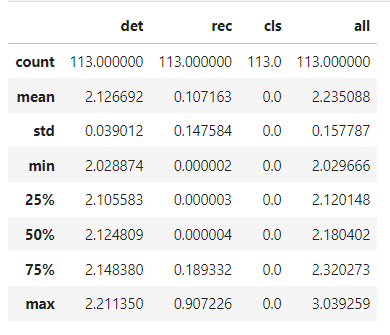

### CPU onnx

In [23]:
OCR_MODEL_CONFIG_PATH = os.path.join(OPR_PATH, "weights/paddleocr/config.yaml")
model_config = OmegaConf.load(OCR_MODEL_CONFIG_PATH)

model_config.det_model_dir = os.path.join(OPR_PATH, "weights/paddleocr/ch_PP-OCRv4_det_infer/inference.onnx")
model_config.return_word_box = False

model_config.rec_model_dir = os.path.join(OPR_PATH, "weights/paddleocr/en_PP-OCRv4_rec_infer/inference.onnx")
model_config.rec_char_dict_path = os.path.join(OPR_PATH, "weights/paddleocr/en_dict.txt")
model_config.rec_algorithm = "SVTR_LCNet"

model_config.use_gpu = torch.cuda.is_available()
model_config.use_onnx = True
model_config.use_mlu = False
model_config.use_gpu = False
model_config.show_log = False

ocr_model = PaddleOcrPipeline(model_config)

In [24]:
image_folder = os.path.join(DATABASE_TRACK_DIR, "2012-01-08/images_large/Cam2/")

limit_recognition = 100
stats_cpu_onnx = []

for image_name in tqdm(os.listdir(image_folder)[:limit_recognition]):
    image_array = cv2.imread(image_folder + image_name)
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    filtered_boxes, rec_res, stat = ocr_model(image_array)
    stats_cpu_onnx.append(stat)

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
df_cpu_onnx = pd.DataFrame(stats_cpu_onnx)

In [27]:
# df_cpu_onnx.describe()

#### RTX 3060

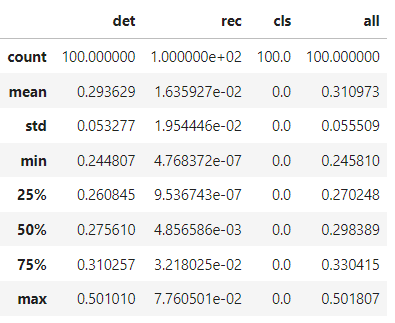

### Jetson

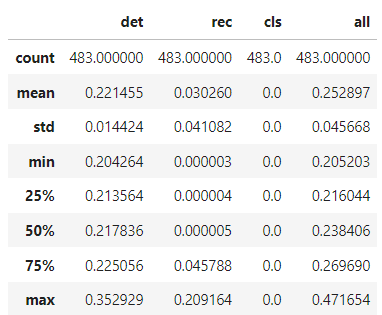

### GPU

In [62]:
OCR_MODEL_CONFIG_PATH = os.path.join(OPR_PATH, "weights/paddleocr/config.yaml")
model_config = OmegaConf.load(OCR_MODEL_CONFIG_PATH)

model_config.det_model_dir = os.path.join(OPR_PATH, "weights/paddleocr/ch_PP-OCRv4_det_infer/")
model_config.return_word_box = False

model_config.rec_model_dir = os.path.join(OPR_PATH, "weights/paddleocr/en_PP-OCRv4_rec_infer/")
model_config.rec_char_dict_path = os.path.join(OPR_PATH, "weights/paddleocr/en_dict.txt")
model_config.rec_algorithm = "SVTR_LCNet"

model_config.use_gpu = torch.cuda.is_available()
model_config.use_onnx = False
model_config.use_mlu = False
model_config.use_gpu = True
model_config.show_log = False

ocr_model = PaddleOcrPipeline(model_config)

In [63]:
image_folder = os.path.join(DATABASE_TRACK_DIR, "2012-01-08/images_large/Cam2/")

limit_recognition = 100
stats_gpu = []

for image_name in tqdm(os.listdir(image_folder)[:limit_recognition]):
    image_array = cv2.imread(image_folder + image_name)
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    filtered_boxes, rec_res, stat = ocr_model(image_array)
    stats_gpu.append(stat)

  0%|          | 0/100 [00:00<?, ?it/s]

In [64]:
df_gpu = pd.DataFrame(stats_gpu)

In [33]:
# df_gpu.describe()

#### RTX 3060

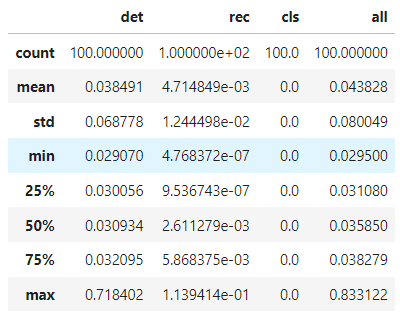

### GPU onnx

In [39]:
OCR_MODEL_CONFIG_PATH = os.path.join(OPR_PATH, "weights/paddleocr/config.yaml")
model_config = OmegaConf.load(OCR_MODEL_CONFIG_PATH)

model_config.det_model_dir = os.path.join(OPR_PATH, "weights/paddleocr/ch_PP-OCRv4_det_infer/inference.onnx")
model_config.return_word_box = False

model_config.rec_model_dir = os.path.join(OPR_PATH, "weights/paddleocr/en_PP-OCRv4_rec_infer/inference.onnx")
model_config.rec_char_dict_path = os.path.join(OPR_PATH, "weights/paddleocr/en_dict.txt")
model_config.rec_algorithm = "SVTR_LCNet"

model_config.use_gpu = torch.cuda.is_available()
model_config.use_onnx = True
model_config.use_mlu = False
model_config.use_gpu = True
model_config.show_log = False

ocr_model = PaddleOcrPipeline(model_config)
provider = 'cuda'
ocr_model.patch_onnx_povider(provider)

In [40]:
image_folder = os.path.join(DATABASE_TRACK_DIR, "2012-01-08/images_large/Cam2/")

limit_recognition = 100
stats_gpu_onnx = []

for image_name in tqdm(os.listdir(image_folder)[:limit_recognition]):
    image_array = cv2.imread(image_folder + image_name)
    image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
    filtered_boxes, rec_res, stat = ocr_model(image_array)
    stats_gpu_onnx.append(stat)

  0%|          | 0/100 [00:00<?, ?it/s]

In [82]:
df_onnx_gpu = pd.DataFrame(stats_gpu_onnx)

In [42]:
# df_onnx_gpu.describe()

#### Jetson

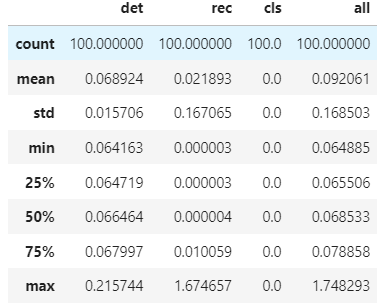

## calculate index.faiss

In [100]:
db_dataloader = DataLoader(
    db_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=db_dataset.collate_fn,
)


In [101]:
descriptors = []
with torch.no_grad():
    for batch in tqdm(db_dataloader):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        final_descriptor = model(batch)["final_descriptor"]
        descriptors.append(final_descriptor.detach().cpu().numpy())

descriptors = np.concatenate(descriptors, axis=0)

  0%|          | 0/9 [00:00<?, ?it/s]

In [102]:
index = faiss.IndexFlatL2(descriptors.shape[1])
index.add(descriptors)
print(index.is_trained)
print(index.ntotal)

True
9


In [103]:
faiss.write_index(index, DATABASE_TRACK_DIR + "/index.faiss")

# Pipeline

In [104]:
ocr_pipe = TextLabelsPlaceRecognitionOCRPipeline(
    db_labels_path=DB_LABELS_PATH,
    database_dir=DATABASE_TRACK_DIR,
    model=model,
    model_weights_path=WEIGHTS_PATH,
    device=DEVICE,
)
ocr_pipe.init_ocr_model(ocr_model)

default_pipe = PlaceRecognitionPipeline(
    database_dir=DATABASE_TRACK_DIR,
    model=model,
    model_weights_path=WEIGHTS_PATH,
    device=DEVICE,
)

### Results only on frames with text labels (TextLabelsPlaceRecognitionOCRPipeline)

In [105]:
import time
from geotransformer.utils.registration import compute_registration_error
from geotransformer.utils.pointcloud import get_transform_from_rotation_translation

In [113]:
PR_MATCH_THRESHOLD = 25.0
pr_matches = []
rre_list = []
rte_list = []
times = []
all_preds = []


for id in tqdm(range(len(query_dataset))):
    data = query_dataset[id]
    gt_pose = data.pop("pose")
    gt_pose = get_transform_from_rotation_translation(Rotation.from_quat(gt_pose[3:]).as_matrix(), gt_pose[:3])

    start_time = time.time()
    pipe_out, ocr_preds = ocr_pipe.infer(data, ocr_predictions=True)
    all_preds.append(ocr_preds)
    times.append(time.time() - start_time)

    estimated_pose = pipe_out["pose"]
    estimated_pose = get_transform_from_rotation_translation(Rotation.from_quat(estimated_pose[3:]).as_matrix(), estimated_pose[:3])

    _, db_match_distance = compute_registration_error(gt_pose, estimated_pose)
    pr_matched = db_match_distance <= PR_MATCH_THRESHOLD
    pr_matches.append(pr_matched)
    
    if pr_matched:
        rre, rte = compute_registration_error(gt_pose, estimated_pose)
        rre_list.append(rre)
        rte_list.append(rte)


  0%|          | 0/275 [00:00<?, ?it/s]

In [108]:
print(f"PlaceRecognition R@1 = {np.mean(pr_matches):0.3f}")
print(f"Localization Mean RRE = {np.mean(rre_list):0.3f}")
print(f"Localization Mean RTE = {np.mean(rte_list):0.3f}")

print(f"Localization Median RRE = {np.median(rre_list):0.3f}")
print(f"Localization Median RTE = {np.median(rte_list):0.3f}")

print(f"Mean Time = {(np.mean(times) * 1000):0.2f} ms")

PlaceRecognition R@1 = 0.091
Localization Mean RRE = 118.473
Localization Mean RTE = 3.617
Localization Median RRE = 120.622
Localization Median RTE = 0.518
Mean Time = 190.28 ms


### Results only on frames with text labels (PlaceRecognitionPipeline)

In [22]:
PR_MATCH_THRESHOLD = 25.0
pr_matches = []
rre_list = []
rte_list = []
times = []


for id in tqdm(range(len(query_dataset))):
    data = query_dataset[id]
    gt_pose = data.pop("pose")
    gt_pose = get_transform_from_rotation_translation(Rotation.from_quat(gt_pose[3:]).as_matrix(), gt_pose[:3])

    start_time = time.time()
    pipe_out = default_pipe.infer(data)
    times.append(time.time() - start_time)

    estimated_pose = pipe_out["pose"]
    estimated_pose = get_transform_from_rotation_translation(Rotation.from_quat(estimated_pose[3:]).as_matrix(), estimated_pose[:3])

    _, db_match_distance = compute_registration_error(gt_pose, estimated_pose)
    pr_matched = db_match_distance <= PR_MATCH_THRESHOLD
    pr_matches.append(pr_matched)

    if pr_matched:
        rre, rte = compute_registration_error(gt_pose, estimated_pose)
        rre_list.append(rre)
        rte_list.append(rte)

  0%|          | 0/275 [00:00<?, ?it/s]

In [23]:
print(f"PlaceRecognition R@1 = {np.mean(pr_matches):0.3f}")
print(f"Localization Mean RRE = {np.mean(rre_list):0.3f}")
print(f"Localization Mean RTE = {np.mean(rte_list):0.3f}")

print(f"Localization Median RRE = {np.median(rre_list):0.3f}")
print(f"Localization Median RTE = {np.median(rte_list):0.3f}")

print(f"Mean Time = {(np.mean(times) * 1000):0.2f} ms")

PlaceRecognition R@1 = 0.000
Localization Mean RRE = nan
Localization Mean RTE = nan
Localization Median RRE = nan
Localization Median RTE = nan
Mean Time = 58.35 ms


In [31]:
len(pr_matches), len(rre_list)

(0, 0)